In [77]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely.ops as so
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import copy
from API_KEY import get_OneMap_token

import importlib
import helper_functions.amenities_dict
importlib.reload(helper_functions.amenities_dict)
import helper_functions.amenities_dict as amenities_dict

In [58]:
save_dir = os.path.join(os.getcwd(),"Data","Road_Networks")

# import car network
filename = "SG_car_network.graphml"
G_car = ox.load_graphml(os.path.join(save_dir,filename))

# import walking network
filename = "SG_walk_network.graphml"
G_walk = ox.load_graphml(os.path.join(save_dir, filename))

# Get OSM amenities

In [2]:
place = {"city": "Singapore", "country": "Singapore"}
tags = {"amenity": True}
amenities_gdf = ox.features_from_place(place, tags)
print(amenities_gdf['amenity'].unique())
print("Number of unique amenities",len(amenities_gdf['amenity'].unique()))
amenities_gdf.head()

['parking_entrance' 'parking' 'toilets' 'fast_food' 'cafe' 'food_court'
 'bank' 'post_office' 'restaurant' 'shelter' 'place_of_worship' 'bench'
 'atm' 'bus_station' 'college' 'telephone' 'fuel' 'bar' 'pub' 'pharmacy'
 'taxi' 'theatre' 'school' 'cinema' 'clock' 'fire_station'
 'vending_machine' 'dentist' 'post_box' 'police' 'recycling'
 'ferry_terminal' 'library' 'fountain' 'brothel' 'kindergarten' 'bbq'
 'waste_basket' 'community_centre' 'bicycle_parking' 'drinking_water'
 'clinic' 'marketplace' 'waste_disposal' 'bar;restaurant' 'shower'
 'grave_yard' 'townhall' 'doctors' 'bicycle_rental' 'ice_cream'
 'nightclub' 'yes' 'university' 'arts_centre' 'prep_school'
 'social_facility' 'car_sharing' 'events_venue' 'veterinary' 'casino'
 'country_club' 'photo_booth' 'reception_desk' 'conference_centre' 'admin'
 'public_building' 'car_rental' 'reception_area' 'parcel_locker'
 'hospital' 'studio' 'bureau_de_change' 'car_wash' 'deli'
 'device_charging_station' 'ticket_validator' 'water_point' 'chi

geometry           amenity  parking  \
element id                                                                
node    245373688  POINT (103.90661 1.30135)  parking_entrance      NaN   
        247342708  POINT (103.80433 1.29535)           parking      NaN   
        254668812  POINT (103.88569 1.32066)  parking_entrance  surface   
        319829990   POINT (103.7318 1.33824)           toilets      NaN   
        368208482  POINT (103.88726 1.39679)         fast_food      NaN   

                                     source    operator  bus highway location  \
element id                                                                      
node    245373688                       NaN         NaN  NaN     NaN      NaN   
        247342708                       NaN         NaN  NaN     NaN      NaN   
        254668812  Kaart Ground Survey 2017         NaN  NaN     NaN      NaN   
        319829990                       NaN         NaN  NaN     NaN      NaN   
        368208482                       NaN  McDonald's  NaN     NaN      NaN   

                         name name:ms  ... short_name:krj short_name:la  \
element id                             ...                                
node    245373688         NaN     NaN  ...            NaN           NaN   
        247342708         NaN     NaN  ...            NaN           NaN   
        254668812         NaN     NaN  ...            NaN           NaN   
        319829990         NaN     NaN  ...            NaN           NaN   
        368208482  McDonald's     NaN  ...            NaN           NaN   

                  short_name:pag short_name:pam short_name:pi long_name  \
element id                                                                
node    245373688            NaN            NaN           NaN       NaN   
        247342708            NaN            NaN           NaN       NaN   
        254668812            NaN            NaN           NaN       NaN   
        319829990            NaN            NaN           NaN       NaN   
        368208482            NaN            NaN           NaN       NaN   

                  phone:1 phone:2 abbr_name garden:type  
element id                                               
node    245373688     NaN     NaN       NaN         NaN  
        247342708     NaN     NaN       NaN         NaN  
        254668812     NaN     NaN       NaN         NaN  
        319829990     NaN     NaN       NaN         NaN  
        368208482     NaN     NaN       NaN         NaN  

[5 rows x 723 columns]

### Amenities Type

In [31]:
amenities_type = list(amenities_gdf['amenity'].unique())
amenities_type
# # export as txt file
# with open(os.path.join(os.getcwd(),"Data",'SG_amenities_type.txt'), 'w') as file:
#     for item in amenities_type:
#         file.write(f"{item}\n")

['parking_entrance',
 'parking',
 'toilets',
 'fast_food',
 'cafe',
 'food_court',
 'bank',
 'post_office',
 'restaurant',
 'shelter',
 'place_of_worship',
 'bench',
 'atm',
 'bus_station',
 'college',
 'telephone',
 'fuel',
 'bar',
 'pub',
 'pharmacy',
 'taxi',
 'theatre',
 'school',
 'cinema',
 'clock',
 'fire_station',
 'vending_machine',
 'dentist',
 'post_box',
 'police',
 'recycling',
 'ferry_terminal',
 'library',
 'fountain',
 'brothel',
 'kindergarten',
 'bbq',
 'waste_basket',
 'community_centre',
 'bicycle_parking',
 'drinking_water',
 'clinic',
 'marketplace',
 'waste_disposal',
 'bar;restaurant',
 'shower',
 'grave_yard',
 'townhall',
 'doctors',
 'bicycle_rental',
 'ice_cream',
 'nightclub',
 'yes',
 'university',
 'arts_centre',
 'prep_school',
 'social_facility',
 'car_sharing',
 'events_venue',
 'veterinary',
 'casino',
 'country_club',
 'photo_booth',
 'reception_desk',
 'conference_centre',
 'admin',
 'public_building',
 'car_rental',
 'reception_area',
 'parcel_lock

### Get amenities (point)

In [74]:
# amenities_gdf[amenities_gdf['name'].str.contains('restaurant',case=False,na=False) == True].head()

amenities_gdf_point = amenities_gdf[amenities_gdf['geometry'].apply(lambda x: any([isinstance(x,Point), isinstance(x,Polygon)]))]
print("Number of point/polygon amenities: ",len(amenities_gdf_point))
# filter amenity and name
amenities_gdf_point = amenities_gdf_point[['geometry','amenity','name','long_name']]
amenities_gdf_point.head()

Number of point/polygon amenities:  27743


geometry           amenity        name  \
element id                                                                   
node    245373688  POINT (103.90661 1.30135)  parking_entrance         NaN   
        247342708  POINT (103.80433 1.29535)           parking         NaN   
        254668812  POINT (103.88569 1.32066)  parking_entrance         NaN   
        319829990   POINT (103.7318 1.33824)           toilets         NaN   
        368208482  POINT (103.88726 1.39679)         fast_food  McDonald's   

                  long_name  
element id                   
node    245373688       NaN  
        247342708       NaN  
        254668812       NaN  
        319829990       NaN  
        368208482       NaN

### Map amenities category to amenities

In [ ]:
amenities_gdf_point = amenities_gdf_point[amenities_gdf_point['amenity'].isin(list(amenities_dict.amenities_dict))]
amenities_gdf_point['amenity_category'] = amenities_gdf_point['amenity'].apply(lambda x: amenities_dict.amenities_dict[x])


# export amenities gdf to geojson as it accept multi-geometries
# amenities_gdf_point.to_file(os.path.join(os.getcwd(),"Data",'SG_amenities.geojson'),driver='GeoJSON')

amenities_gdf_point.head()

geometry    amenity        name long_name  \
element id                                                                      
node    247342708  POINT (103.80433 1.29535)    parking         NaN       NaN   
        368208482  POINT (103.88726 1.39679)  fast_food  McDonald's       NaN   
        368261001  POINT (103.88629 1.38936)       cafe         NaN       NaN   
        369123937  POINT (103.90146 1.38529)  fast_food  McDonald's       NaN   
        369123954  POINT (103.90142 1.38523)  fast_food         KFC       NaN   

                     amenity_category  
element id                             
node    247342708             neutral  
        368208482             neutral  
        368261001  high_value_amenity  
        369123937             neutral  
        369123954             neutral

Length of amenities df:  20913


,element,id,amenity,name,long_name,amenity_category,geometry
0,node,247342708,parking,None,None,neutral,POINT (103.80433 1.29535)
1,node,368208482,fast_food,McDonald's,None,high_value_amenity,POINT (103.88726 1.39679)
2,node,368261001,cafe,None,None,high_value_amenity,POINT (103.88629 1.38936)
3,node,369123937,fast_food,McDonald's,None,high_value_amenity,POINT (103.90146 1.38529)
4,node,369123954,fast_food,KFC,None,high_value_amenity,POINT (103.90142 1.38523)


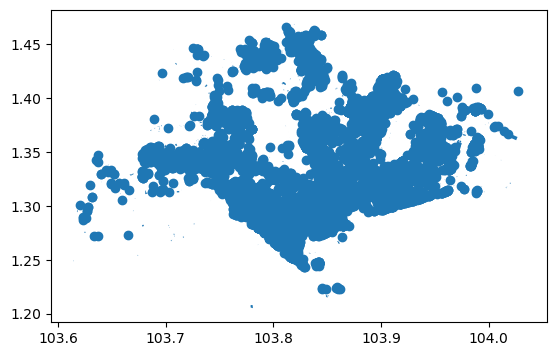

In [64]:
amenities_df = gpd.read_file(os.path.join(os.getcwd(),"Data",'SG_amenities.geojson'))
amenities_df.plot()
print("Length of amenities df: ", len(amenities_df))
amenities_df.head()

# Get building footprints (polygons)

In [21]:
# configure the place, network type, trip times, and travel speed
place = {"city": "Singapore", "country": "Singapore"}
# get all building footprints in some neighborhood
# `True` means retrieve any object with this tag, regardless of value
tags = {"building": True}
buildingFootprint = ox.features_from_place(place, tags)
# filter only polygon geometry, exclude point
buildingFootprint = buildingFootprint[buildingFootprint['geometry'].apply(lambda x: isinstance(x,Polygon))]
buildingFootprint.head()

geometry addr:city  \
element  id                                                                     
relation 1337396  POLYGON ((103.96113 1.33718, 103.96154 1.33692...       NaN   
         1362701  POLYGON ((103.84941 1.35084, 103.84937 1.35088...       NaN   
         1407265  POLYGON ((104.03053 1.40727, 104.03046 1.40708...       NaN   
         1447583  POLYGON ((103.95783 1.34956, 103.95794 1.34944...       NaN   
         1447589  POLYGON ((103.95815 1.34884, 103.95811 1.34879...       NaN   

                 addr:country addr:housename addr:housenumber addr:postcode  \
element  id                                                                   
relation 1337396          NaN            NaN              NaN           NaN   
         1362701          NaN            NaN              NaN           NaN   
         1407265          NaN            NaN              NaN           NaN   
         1447583          NaN            NaN              NaN           NaN   
         1447589          NaN            NaN              NaN           NaN   

                 addr:street bench  bin building  ... seamark:name  \
element  id                                       ...                
relation 1337396         NaN   NaN  NaN      yes  ...          NaN   
         1362701         NaN   NaN  NaN   garage  ...          NaN   
         1407265         NaN   NaN  NaN      yes  ...          NaN   
         1447583         NaN   NaN  NaN      yes  ...          NaN   
         1447589         NaN   NaN  NaN      yes  ...          NaN   

                 seamark:radar_transponder:category  \
element  id                                           
relation 1337396                                NaN   
         1362701                                NaN   
         1407265                                NaN   
         1447583                                NaN   
         1447589                                NaN   

                 seamark:radar_transponder:group          type multipolygon  \
element  id                                                                   
relation 1337396                             NaN  multipolygon          NaN   
         1362701                             NaN  multipolygon          NaN   
         1407265                             NaN  multipolygon          NaN   
         1447583                             NaN  multipolygon          NaN   
         1447589                             NaN  multipolygon          NaN   

                 levels building:1992-2017 name:1992-2017 garden:type  \
element  id                                                             
relation 1337396    NaN                NaN            NaN         NaN   
         1362701    NaN                NaN            NaN         NaN   
         1407265    NaN                NaN            NaN         NaN   
         1447583    NaN                NaN            NaN         NaN   
         1447589    NaN                NaN            NaN         NaN   

                 roof:cover:material  
element  id                           
relation 1337396                 NaN  
         1362701                 NaN  
         1407265                 NaN  
         1447583                 NaN  
         1447589                 NaN  

[5 rows x 522 columns]

In [41]:
buildingFootprint[buildingFootprint['name'].str.contains('mall',case=False,na=False)]

geometry  \
element  id                                                              
relation 4131242     POLYGON ((103.94176 1.37852, 103.94172 1.3786,...   
way      32774374    POLYGON ((103.90426 1.39265, 103.90399 1.39227...   
         32774665    POLYGON ((103.8934 1.37232, 103.89346 1.37226,...   
         33444529    POLYGON ((103.88492 1.35911, 103.88469 1.35936...   
         37397540    POLYGON ((103.8474 1.37298, 103.84788 1.37303,...   
         46522833    POLYGON ((103.8493 1.30097, 103.84974 1.30082,...   
         46612311    POLYGON ((103.8237 1.3045, 103.82369 1.30455, ...   
         71395044    POLYGON ((103.76752 1.35964, 103.76753 1.35959...   
         95594924    POLYGON ((103.69687 1.34158, 103.697 1.34141, ...   
         102429452   POLYGON ((103.85594 1.31144, 103.85656 1.31077...   
         104000621   POLYGON ((103.84436 1.35846, 103.84432 1.35787...   
         111610945   POLYGON ((103.88518 1.30815, 103.88533 1.30782...   
         116782195   POLYGON ((103.92954 1.3264, 103.92975 1.32595,...   
         117227770   POLYGON ((103.83738 1.37453, 103.83715 1.37462...   
         118994815   POLYGON ((103.76367 1.31456, 103.76365 1.31454...   
         119879842   POLYGON ((103.76492 1.31444, 103.76503 1.31449...   
         162524446   POLYGON ((103.74959 1.3502, 103.74924 1.35049,...   
         166194030   POLYGON ((103.94425 1.35264, 103.94426 1.35258...   
         167472305   POLYGON ((103.78865 1.30544, 103.78862 1.30551...   
         170403423   POLYGON ((103.84723 1.33291, 103.8471 1.33286,...   
         172364980   POLYGON ((103.85586 1.2983, 103.85583 1.29826,...   
         172518487   POLYGON ((103.82847 1.30593, 103.82838 1.30598...   
         173131856   POLYGON ((103.74463 1.38561, 103.74464 1.38544...   
         190945744   POLYGON ((103.86047 1.29971, 103.86048 1.29968...   
         233150122   POLYGON ((103.87655 1.39131, 103.87657 1.3913,...   
         271791475   POLYGON ((103.8467 1.32743, 103.84671 1.32727,...   
         288997556   POLYGON ((103.87295 1.30476, 103.87271 1.30475...   
         305950830   POLYGON ((103.89398 1.3721, 103.89386 1.37199,...   
         306112498   POLYGON ((103.89959 1.33266, 103.89925 1.33238...   
         364073828   POLYGON ((103.76241 1.37873, 103.76317 1.37891...   
         368005264   POLYGON ((103.74765 1.33212, 103.74794 1.3326,...   
         372165964   POLYGON ((103.8432 1.28883, 103.84321 1.28898,...   
         375020383   POLYGON ((103.76398 1.36268, 103.76401 1.36285...   
         397426426   POLYGON ((103.882 1.38458, 103.88201 1.38457, ...   
         408630599   POLYGON ((103.8687 1.3323, 103.86812 1.33174, ...   
         439189301   POLYGON ((103.86214 1.31917, 103.86217 1.3192,...   
         445001361   POLYGON ((103.84168 1.41842, 103.84096 1.41869...   
         455160297   POLYGON ((103.8177 1.32101, 103.81773 1.32116,...   
         463063314   POLYGON ((103.89329 1.31721, 103.8928 1.31714,...   
         465145060   POLYGON ((103.86469 1.31046, 103.86475 1.31035...   
         474909150   POLYGON ((103.87903 1.33192, 103.87909 1.33164...   
         502013652   POLYGON ((103.77954 1.43373, 103.77955 1.43374...   
         561552026   POLYGON ((103.90396 1.30494, 103.90402 1.30498...   
         599416637   POLYGON ((103.74045 1.35612, 103.74046 1.3561,...   
         675585724   POLYGON ((103.93017 1.32443, 103.93016 1.32433...   
         989257851   POLYGON ((103.88839 1.33416, 103.88847 1.33386...   
         1028775892  POLYGON ((103.87206 1.33803, 103.87211 1.33803...   
         1122039326  POLYGON ((103.8929 1.38406, 103.89293 1.38421,...   
         1162445410  POLYGON ((103.94891 1.37277, 103.9488 1.3728, ...   
         1167087012  POLYGON ((103.94393 1.3545, 103.944 1.35456, 1...   
         1184145477  POLYGON ((103.77494 1.36696, 103.77517 1.36696...   
         1294482734  POLYGON ((103.83948 1.2928, 103.83971 1.29312,...   

                     addr:city addr:country     addr:housename  \

# Scrap list of current malls in Singapore

In [44]:

URL = "https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore"
page = requests.get(URL)
# parse HTML
soup = BeautifulSoup(page.content, "html.parser")

# Step 1: Find the <th> element with "Current malls"
current_malls_header = soup.find("th", string="Current malls")

# Step 2: Get the corresponding <td> next to it
current_malls_td = current_malls_header.find_next_sibling("td")

# Step 3: Extract all <a> tags inside that <td>
current_malls = []
for a in current_malls_td.find_all("a"):
    name = a.text.strip()
    if name:
        current_malls.append(name)

# Print or use the mall names
print(current_malls)

['Alexandra Retail Centre', 'AMK Hub', 'Bedok Mall', 'Bugis Junction', 'Bugis+', 'Capitol Singapore', 'Causeway Point', 'Century Square', 'Change Alley', 'Changi City Point', 'Chinatown Point', 'City Square Mall', 'CityLink Mall', 'Clementi Mall', 'Compass One', 'Djitsun Mall', 'Eastpoint Mall', 'Esplanade Mall', 'Far East Plaza', 'Forum The Shopping Mall', 'Fu Lu Shou Complex', 'Funan', 'Great World', 'HarbourFront Centre', 'Hillion Mall', 'Holland Road Shopping Centre', 'Hougang 1', 'Hougang Mall', 'i12 Katong', 'IMM', 'ION Orchard', 'Jem', 'Jewel Changi Airport', 'Junction 10', 'Junction 8', 'Jurong Point', 'Kallang Wave Mall', 'Katong Shopping Centre', 'Leisure Park Kallang', 'Lot One', 'Lucky Plaza', 'Mandarin Gallery', 'Marina Bay Link Mall', 'The Shoppes at Marina Bay Sands', 'Marina Square', 'Millenia Walk', 'Mustafa Centre', 'Nex', 'Ngee Ann City', 'Northpoint City', 'Novena Square', 'Orchard Central', 'Orchard Gateway', 'Orchard Towers', 'Palais Renaissance', 'The Paragon', '

In [ ]:
# export as txt file
# with open(os.path.join(os.getcwd(),"Data",'SG_current_malls.txt'), 'w') as file:
#     for item in current_malls:
#         file.write(f"{item}\n")

In [48]:
# TODO: use onemap to get all the coordinates of the malls and export as shapefile
def generate_OneMap_headers():
    """ generates new one map token """
    onemapKey = get_OneMap_token()
    headers = {"Authorization": onemapKey}
    return headers

def get_coordinates_from_location(location,headers):
    """returns number of results found, search value, and coordinates given a supplied location 
    Args:
        location (str): a location in singapore
    Returns:
        tuple: strings corresponding to number of results found, search value, lat, and lon
    """
    
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={location}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
        
    response = requests.request("GET", url, headers=headers)
    response = response.json()
    response_first_result = response['results'][0] # get first item in the list
    return response_first_result

headers = generate_OneMap_headers()
searchVal = get_coordinates_from_location(current_malls[0],headers=headers)
searchVal

{'SEARCHVAL': 'ALEXANDRA RETAIL CENTRE (ARC)',
 'BLK_NO': '460',
 'ROAD_NAME': 'ALEXANDRA ROAD',
 'BUILDING': 'ALEXANDRA RETAIL CENTRE (ARC)',
 'ADDRESS': '460 ALEXANDRA ROAD ALEXANDRA RETAIL CENTRE (ARC) SINGAPORE 119963',
 'POSTAL': '119963',
 'X': '24447.647553565',
 'Y': '28514.458416285',
 'LATITUDE': '1.27414893629254',
 'LONGITUDE': '103.801399416665'}

In [66]:
mall_list = []
missing_malls = ['112 katong', 'shaw centre','yewtee point']
for s in current_malls + missing_malls:
    try:
        if s == 'HDB malls':
            print(s)
            pass
        else:
            searchVal = get_coordinates_from_location(s,headers=headers)
            searchVal['Mall Name'] = s
            mall_list.append(searchVal)
    except Exception as e:
        print(f"{s}: {e}")

mall_df = pd.DataFrame(mall_list)
mall_df.head()

Change Alley: list index out of range
i12 Katong: list index out of range
Shaw House and Centre: list index out of range
Yew Tee Point: list index out of range
Multiplexes: list index out of range


,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,Mall Name
0,ALEXANDRA RETAIL CENTRE (ARC),460,ALEXANDRA ROAD,ALEXANDRA RETAIL CENTRE (ARC),460 ALEXANDRA ROAD ALEXANDRA RETAIL CENTRE (AR...,119963,24447.647553565,28514.458416285,1.27414893629254,103.801399416665,Alexandra Retail Centre
1,AMK HUB,53,ANG MO KIO AVENUE 3,AMK HUB,53 ANG MO KIO AVENUE 3 AMK HUB SINGAPORE 569933,569933,29687.0565410079,39045.6241728477,1.36938922690344,103.84847796594,AMK Hub
2,BEDOK MALL,311,NEW UPPER CHANGI ROAD,BEDOK MALL,311 NEW UPPER CHANGI ROAD BEDOK MALL SINGAPORE...,467360,38676.9034392368,34108.3360637221,1.32473632784728,103.929256259998,Bedok Mall
3,BUGIS JUNCTION,200,VICTORIA STREET,BUGIS JUNCTION,200 VICTORIA STREET BUGIS JUNCTION SINGAPORE 1...,188021,30458.7085178969,31274.8305191435,1.29911287475873,103.855411173758,Bugis Junction
4,BUGIS CUBE,470,NORTH BRIDGE ROAD,BUGIS CUBE,470 NORTH BRIDGE ROAD BUGIS CUBE SINGAPORE 188735,188735,30483.6570850834,31167.3475166354,1.2981408343975,103.855635339249,Bugis+


### Get nodesID for malls

In [67]:
# assign nodes to get proximity to malls
mall_df[['LONGITUDE','LATITUDE']] = mall_df[['LONGITUDE','LATITUDE']].apply(pd.to_numeric, errors='coerce')
mall_df['nodesID_car_mall'] = ox.nearest_nodes(G_car,X=mall_df['LONGITUDE'], Y=mall_df['LATITUDE'])
mall_df['nodesID_walk_mall'] = ox.nearest_nodes(G_walk,X=mall_df['LONGITUDE'], Y=mall_df['LATITUDE'])
# convert to geopandas df
mall_df = gpd.GeoDataFrame(mall_df, geometry=gpd.points_from_xy(mall_df['LONGITUDE'], mall_df['LATITUDE']), crs="EPSG:4326")
mall_df.head()

,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,Mall Name,nodesID_car_mall,nodesID_walk_mall,geometry
0,ALEXANDRA RETAIL CENTRE (ARC),460,ALEXANDRA ROAD,ALEXANDRA RETAIL CENTRE (ARC),460 ALEXANDRA ROAD ALEXANDRA RETAIL CENTRE (AR...,119963,24447.647553565,28514.458416285,1.274149,103.801399,Alexandra Retail Centre,435833857,5269394155,POINT (103.8014 1.27415)
1,AMK HUB,53,ANG MO KIO AVENUE 3,AMK HUB,53 ANG MO KIO AVENUE 3 AMK HUB SINGAPORE 569933,569933,29687.0565410079,39045.6241728477,1.369389,103.848478,AMK Hub,435824984,4540628535,POINT (103.84848 1.36939)
2,BEDOK MALL,311,NEW UPPER CHANGI ROAD,BEDOK MALL,311 NEW UPPER CHANGI ROAD BEDOK MALL SINGAPORE...,467360,38676.9034392368,34108.3360637221,1.324736,103.929256,Bedok Mall,4675722406,8982593125,POINT (103.92926 1.32474)
3,BUGIS JUNCTION,200,VICTORIA STREET,BUGIS JUNCTION,200 VICTORIA STREET BUGIS JUNCTION SINGAPORE 1...,188021,30458.7085178969,31274.8305191435,1.299113,103.855411,Bugis Junction,232119579,4755817437,POINT (103.85541 1.29911)
4,BUGIS CUBE,470,NORTH BRIDGE ROAD,BUGIS CUBE,470 NORTH BRIDGE ROAD BUGIS CUBE SINGAPORE 188735,188735,30483.6570850834,31167.3475166354,1.298141,103.855635,Bugis+,232119579,11037228265,POINT (103.85564 1.29814)


In [68]:
# export as shapefile
mall_df.to_file(os.path.join(os.getcwd(),"Data",'SG_malls.geojson'), driver='GeoJSON')

### Add proximity to trees and parks

In [70]:
# add a buffer of 400m
def add_buffer(gdf,buffer_dist=400, crs="EPSG:4326",plot=True):
    """ 
    returns a GeoSeries (polygon geometry) of the buffered area
    Args:
        gdf (Geo.DataFrame)
        buffer_dist (float): distance in meters
        plot (bool): If True, plot geoseries of the buffered area
    Returns:
        gpd.GeoSeries
    """
    gdf_buffer = gdf.to_crs({'proj':'cea'})
    gdf_buffer = gdf_buffer['geometry'].buffer(buffer_dist)
    gdf_buffer = gdf_buffer.to_crs(crs)
    if plot:
        gdf_buffer.plot(fc="None", ec="k",alpha=0.7)

    return gdf_buffer

<Axes: >

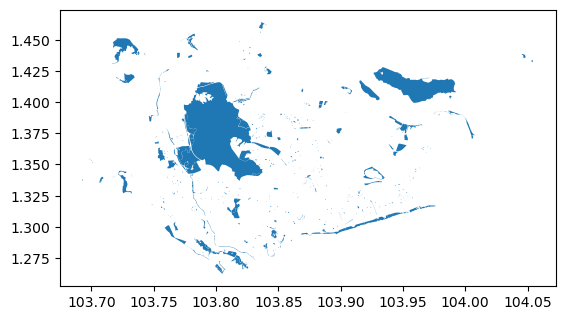

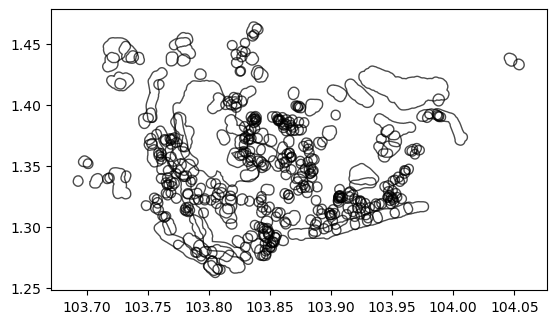

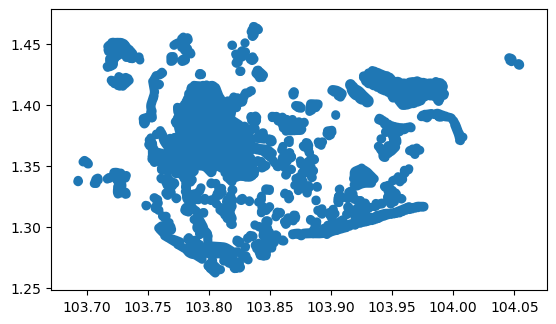

In [71]:
parks_df = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents - Heat Risk Index Development\Data\Parks\NParksParksandNatureReserves.geojson")
parks_df.plot()
parks_df['geometry'] = add_buffer(parks_df,buffer_dist=400, crs="EPSG:4326",plot=True)
parks_df.plot()

# Get OneMap themes

In [81]:
import requests
    
url = "https://www.onemap.gov.sg/api/public/themesvc/retrieveTheme?queryName=dengue_cluster"

headers = generate_OneMap_headers()
response = requests.request("GET", url, headers=headers)
    
print(response.json())

{'SrchResults': [{'FeatCount': 16, 'Theme_Name': 'Dengue Clusters', 'Category': 'Health', 'Owner': 'NATIONAL ENVIRONMENT AGENCY', 'DateTime': '2025-07-28T15:36:00+00:00', 'Published_Date': '2013-06-26T00:00:00+00:00', 'Formatted_DateTime': '28/07/2025', 'Formatted_Published_Date': '26/06/2013'}, {'NAME': 'Dengue_Cluster', 'DESCRIPTION': 'Cactus Dr (Grande Vista) / Sunrise Ter', 'HYPERLINK': 'https://www.nea.gov.sg/dengue-zika/dengue/dengue-clusters', 'CASE_SIZE': '54', 'HOMES': 'Plastic scoop, Flower pot plate, Vase, Planter box, Water fountain, Watering can, Flowerpot trove, Tree stump, Water can', 'PUBLIC_PLACES': 'Gully trap, Planted area, Closed perimeter drain, Puddle', 'MAPTIP': 'Dengue_Cluster', 'SYMBOLCOLOR': '#FFFFFF', 'Type': 'Polygon', 'LatLng': [[103.851662700324, 1.38899425903408], [103.851899825821, 1.38897887393823], [103.853624006274, 1.38885505494485], [103.854195706892, 1.38901343302674], [103.854928918479, 1.38903605268383], [103.854934406203, 1.38914725957066], [103

<Axes: >

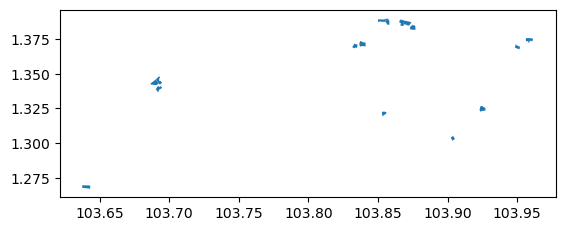

In [98]:
from shapely.geometry import shape
x = response.json()
x = x['SrchResults']
polys = []
for r in range(len(x)):
    try:
        polys.append(x[r]['GeoJSON']['geometry'])
    except:
        pass

geom = [shape(i) for i in polys]
geom = gpd.GeoDataFrame({'geometry':geom})
geom.plot()